# Basic signal processing with Python

<img width=150px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png">

_Made by Alexandre Fournier (fournier@ipgp.fr), modified by Léonard Seydoux (seydoux@ipgp.fr) in 2023 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr)._

## Table of contents

1. [Introduction](#1.-Introduction)
    1. [Goals](#1.1.-Goals)
    2. [Importing modules](#1.2.-Importing-modules)
2. [Synthetic data](#2.-Synthetic-data)
    1. [Synthetic monochromatic data](#2.1.-Synthetic-monochromatic-data)
    2. [Synthetic multi-component signal](#2.2.-Synthetic-multi-component-signal)
    3. [Spectral analysis](#2.3.-Spectral-analysis)
    4. [Filtering](#2.4.-Filtering)
3. [Real data analysis](#3.-Real-data-analysis)
    1. [Loading the data](#3.1.-Loading-the-data)
    2. [Spectral analysis](#3.2.-Spectral-analysis)
    3. [Filtering](#3.3.-Filtering)
    4. [Correlating with the sunspot number](#3.4.-Correlating-with-the-sunspot-number) 

## 1. Introduction

### 1.1. Goals

This Jupyter Notebook provides examples of basic signal processing with Python. It covers topics such as generating synthetic time series, computing Fourier transforms, and applying filters to signals. The examples use the `numpy`, `scipy`, and `matplotlib` libraries. The notebook is organized into cells, each containing a block of code that can be executed independently. If a module is already imported in a cell, it can be used in other cells as well. For the same reason, if a variable is defined in a cell, it can be used in other cells as well. We should not repeat the same import or variable definition in multiple cells, unless we want to overwrite the previous definition.

### 1.2. Importing modules

To get started, run the cells in order, starting from the top. Each cell builds on the previous one, so it's important to run them in order. Note that this notebook assumes some familiarity with Python and signal processing concepts. If you're new to these topics, you may want to review some introductory material before diving in. Every python function is documented on the internet. google the name of the function will provide you with the link to its online description. For example, see
[http://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html](http://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal 

import synthetic

## 2. Synthetic data

### 2.1. Synthetic monochromatic signal

In this section, we will generate a synthetic time series and explore its properties. The time series is defined as

$$
s(t) = \sin(2\pi t/T + \phi),
$$

where $T$ is the period of the signal, $t$ is the continuous time, and $\phi$ is the phase of the signal. In practice, we will generate a discrete time series, where the time $t$ is sampled at discrete intervals $dt$. The discrete time series $s[n]$ is defined as

$$
s[n] = \sin(2\pi n \delta t/T + \phi), \quad n = 0, 1, 2, \ldots, N-1,
$$

where $N$ is the total number of samples in the time series, and $n \delta t$ is the discrete time. For the sake of simplicity, we will keep the notation $s(t)$ for the discrete time series, keeping in mind that we must choose $\delta t$ carefully to avoid sampling problems.

As we will deal with geomatic data later on, we will generate synthetic data with equivalent units. The time series will span from years 1850 to 2010, and will contain a single harmonic component of period $T = $ 10 years. The timeseries will be evenly sampled every 12th of a year (_i.e._, $\delta t = 1$ month). To generate the synthetic timeseries, we will use the `time_range` and `sine()` functions from the `synthetic` Python module. These functions allow us to define a time window and a cosine time series, respectively.

> __Question 1.__ What is the maximum time step $\delta t$ that we can use to sample the synthetic time series correctly? Can you give a general formula for the minimum time step that we can use to sample a timeseries with a given period? What effect do you expect to see if you use a time step that is too large?

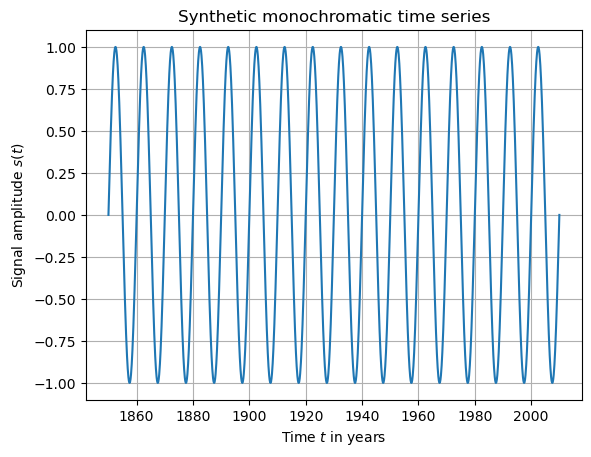

In [4]:
# Time extent of the time series
time_start = 1850
time_end = 2010
time_step = 1 / 12
times = synthetic.time_range(time_start, time_end, time_step)

# Generate a synthetic time series
period = 10
amplitude = 1
phase = -2 * np.pi * time_start / period
time_series_monochromatic = synthetic.sine(times, period, amplitude, phase)

# Plot
fig, ax = plt.subplots()
ax.plot(times, time_series_monochromatic)
ax.set_xlabel("Time $t$ in years")
ax.set_ylabel("Signal amplitude $s(t)$")
ax.set_title("Synthetic monochromatic time series")
ax.grid()
plt.show()

### 2.2. Synthetic multi-component signal

We will now generate a synthetic time series $v(t)$ that contains multiple harmonic components. The time series is defined as

$$
v(t) = \sum_{i=1}^{K} s_i(t) = \sum_{i=1}^{K} \alpha_i \sin \left( 2 \pi t / T_i +\phi_i \right),
$$

where $K$ is the number of components, $\alpha_i$ is the amplitude of the $i$-th component, $T_i$ is the period of the $i$-th component, and $\varphi_i$ is the phase of the $i$-th component. 

> __Question 2.__ Using the python functions at your disposal in the `synthetic` Python module and the code from the previous cell, create a synthetic timeseries spanning the 1850 to 2010 time range (with one point every month), comprising four harmonic components, of periods in years given by
> 
> $$
> \left \{
> \begin{align*}
> T_1 &= 0.5, \\
> T_2 &= 1, \\
> T_3 &= 11, \\
> T_4 &= 60. \\
> \end{align*} 
> \right .
> $$
>
> You can arbitrarily set the amplitude $\alpha_i$ and the phase $\varphi_i$ of each of these components.

### 2.3 Spectral analysis

We now wish to analyse the spectral content of the signals we just generated. We will start with the monochromatic signal $s(t)$, and then move on to the multi-component signal $v(t)$. 

We here recall the definition of the Fourier transform of a signal $s(t)$, which is defined as

$$
\hat{s}(f) = \int_{-\infty}^{\infty} s(t) e^{-2\pi i f t} dt,
$$

where $f$ is the frequency (inverse of the period) and $\hat{s}(f)$ is the Fourier transform of $s(t)$. The _Discrete Fourier Transform_ (DFT) of a discrete time series $s[n]$ is defined as

$$
\hat{s}[k] = \sum_{n=0}^{N-1} s[n] e^{-2\pi i k n / N},
$$

where $k$ is the frequency index and $\hat{s}[k]$ is the DFT of $s[n]$. The DFT is computed using the Fast Fourier Transform (FFT) algorithm, which is implemented in the `numpy.fft.fft` function. The FFT algorithm is very efficient, and can be used to compute the DFT of a time series with a large number of samples. Again, for the sake of simplicity, we will keep the notation $\hat{s}(f)$ for the DFT of $s(t)$, keeping in mind that we must choose $\delta t$ carefully to avoid sampling problems. Also note that the output of a Fourier transformis a complex function. We can always use the notation

$$
\hat{s}(f) = A(f) e^{i \phi(f)},
$$

where $A(f)$ is the spectral amplitude and $\phi(f)$ is the spectral phase. We usally plot the spectral amplitude $A(f)$, which is a real function as a function of the frequency $f$. The spectral amplitude is defined as the modulus of the Fourier transform, _i.e._,

$$
A(f) = \left | \hat{s}(f) \right | = \sqrt{\hat{s}(f) \hat{s}^*(f)},
$$

where $\hat{s}^*(f)$ is the complex conjugate of $\hat{s}(f)$. We also name the square of the spectral amplitude the _power spectrum_ of the signal, or the _power spectral density_ (PSD). 

You can run the cell below to observe the spectrum of the monochromatic signal $s(t)$ as a function of the frequency $f$. We display the spectrum as a function of the log of the frequency, which is more convenient for visualizing the spectrum. 

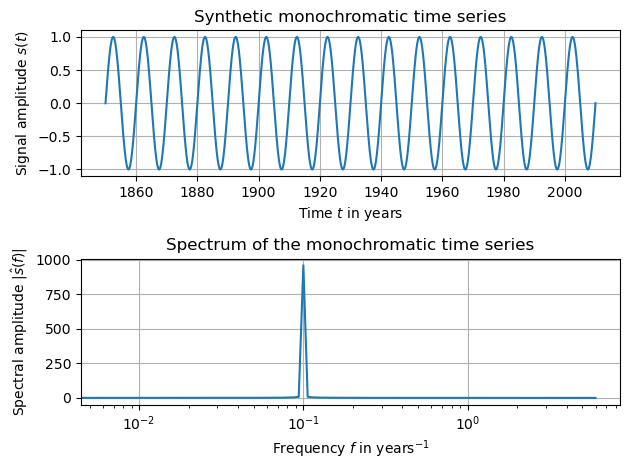

In [6]:
# Compute the Fourier transform
spectrum = np.fft.rfft(time_series_monochromatic)
spectral_amplitude = np.abs(spectrum)

# Calculate frequencies
frequencies = np.fft.rfftfreq(len(time_series_monochromatic), time_step)

# Prepare the plot
fig, ax = plt.subplots(2)

# Plot the time series
ax[0].plot(times, time_series_monochromatic)
ax[0].set_xlabel("Time $t$ in years")
ax[0].set_ylabel("Signal amplitude $s(t)$")
ax[0].set_title("Synthetic monochromatic time series")
ax[0].grid()

# Plot the spectrum
ax[1].semilogx(frequencies, spectral_amplitude)
ax[1].set_xlabel("Frequency $f$ in years$^{-1}$")
ax[1].set_ylabel("Spectral amplitude $|\hat{s}(f)|$")
ax[1].set_title("Spectrum of the monochromatic time series")
ax[1].grid()

# Show
fig.tight_layout()
plt.show()

> __Question 3.__ Adapt the code below to the multi-component signal you created in 1.2. Plot the spectrum of the signal. What do you observe?

### 2.4. Filtering

In many ways we can understand the concept of filtering an input signal $x(t)$ to visualize its amplitude of a function of time at particular frequencies. For instance, thanks to the inverse transform, you can imagine designing a filter $h(f)$ such that when applied to the Fourier transform of the input signal $\hat{x}(f)$, it will only keep the amplitude of the signal in a particular range of frequencies. The filtered signal $\hat{y}(f)$ is then given by

$$
\hat{y}(f) = \hat{x}(f) h(f).
$$

The filtered signal in time domain is then given by the inverse Fourier transform of $\hat{y}(f)$, _i.e._, $y(t) = \mathcal{F}^{-1} \left \{ \hat{y}(f) \right \}$. We distinguish four types of filters: low-pass, high-pass, band-pass, and band-stop filters. The names of these filters are pretty self-explanatory. 

Note that in practice, not all filters are defined in the frequency domain. For different reasons, some filters can be defined in the time domain, or from recursive relations. In this notebook, we will use the `scipy.signal` package to apply filters to our signals. This package provides a large number of filters, including Butterworth, Chebyshev, and Bessel filters. The package also provides functions to design filters, such as the `butter` function, which designs a Butterworth filter. The `scipy.signal` package also provides functions to apply filters to signals, such as the `lfilter` function, which applies a filter to a signal.

Now let us get acquainted with the Butterworth filters provided by the `scipy.signal` processing package of scientific python. The example below shows how to apply a bandpass filter, with corner periods equal to 5 and 15 years, to the example time series we have been using so far. 

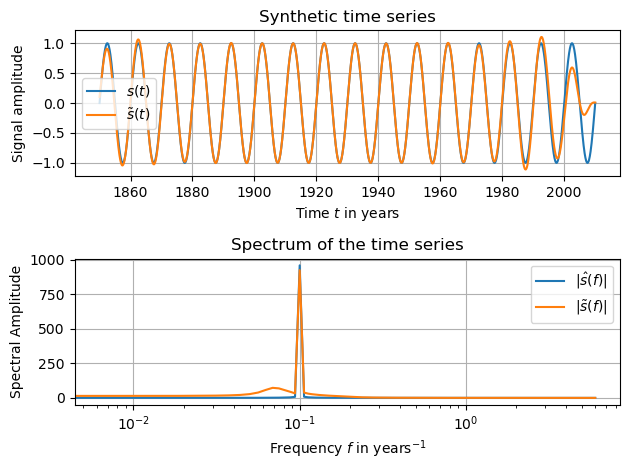

In [7]:
# Butterworth filter properties
period_max = 15
period_min = 5

# Get the Nyquist frequency
sampling_rate = 1 / time_step
nyquist_frequency = sampling_rate / 2

# Convert to angular frequencies
frequency_low = 1 / period_max
omega_low = frequency_low / nyquist_frequency
frequency_high = 1 / period_min
omega_high = frequency_high / nyquist_frequency

# Filter order
b, a = signal.butter(4, [omega_low, omega_high], btype="bandpass")

# Filter the time series
filtered = signal.filtfilt(b, a, time_series_monochromatic)

# Get spectrum
spectrum = np.fft.rfft(time_series_monochromatic)
spectrum_filtered = np.fft.rfft(filtered)
frequencies = np.fft.rfftfreq(len(time_series_monochromatic), time_step)

# Prepare the plot
fig, ax = plt.subplots(2)

# Plot the time series
ax[0].plot(times, time_series_monochromatic, label="$s(t)$")
ax[0].plot(times, filtered, label=r"$\tilde{s}(t)$")
ax[0].set_xlabel("Time $t$ in years")
ax[0].set_ylabel("Signal amplitude")
ax[0].set_title("Synthetic time series")
ax[0].legend()
ax[0].grid()

# Plot the spectrum
ax[1].semilogx(frequencies, np.abs(spectrum), label="$|\hat{s}(f)|$")
ax[1].semilogx(frequencies, np.abs(spectrum_filtered), label=r"$|\tilde{s}(f)|$")
ax[1].set_xlabel("Frequency $f$ in years$^{-1}$")
ax[1].set_ylabel("Spectral Amplitude")
ax[1].set_title("Spectrum of the time series")
ax[1].legend()
ax[1].grid()

# Show
fig.tight_layout()
plt.show()

> __Question 4.__. Your turn now: extract in $v(t)$ the $11$-year component. Plot the filtered signal against the original one, and compare as well its spectrum to the original one. By looking at the manual page of `scipy.signal.filtfilt`, the default version of which we use, suggest a way of improving the reconstruction of the sought harmonic component. This improvement can follow from the artificial augmentation of the length of the timeseries (padding it with zeros), which tends to mitigate spurious edge effects on the filtered signal.

## 3. Real data analysis

We will now analyze the geomagnetic measurements recorded at the geomagnetic observatory of Chambon-la-Forêt (CLF), France over 78 years. The data are provided by the [Bureau Central de Magnétisme Terrestre](http://www.bcmt.fr) (BCMT) and stored in the file [data/chambon_la_foret.dat](data/chambon_la_foret.dat) that contains the monthly means of the geomagnetic elements recorded at the CLF observatory. You can investigate the file manually to see how the data are organized.

### 3.1. Loading the data

The cell below reads the file and and plots the fluctuations of the vertical component at the site between 1936 and 2015. It uses the Pandas library, which is a powerful library for data analysis. The Pandas library provides a `read_fwf` function that allows us to read a fixed-width file and store the data in a Pandas dataframe. A dataframe is a data structure that is similar to a table, where each column is a variable and each row is an observation. The Pandas library also provides a `plot` function that allows us to plot the data in a dataframe. The `plot` function is a wrapper around the `matplotlib` library, which is a powerful library for plotting data. 

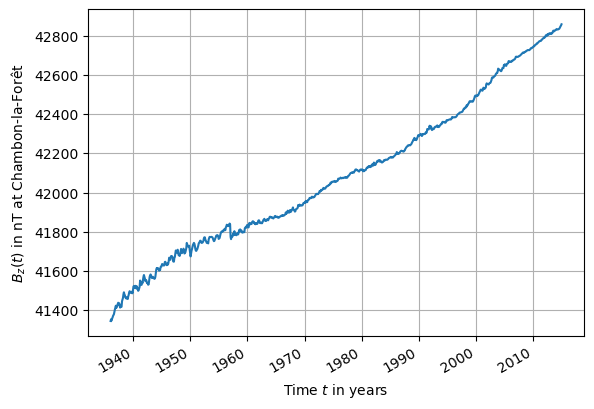

In [8]:
# Path to the data
filename = "data/chambon_la_foret.dat"

# Load the data
data = pd.read_fwf(filename, skiprows=9, strip=True)

# Turn years into datetime objects
# First, concatenate the year and month columns
date_time_concatenated = data.date.astype(str) + " " + data.time.astype(str)

# Then, convert to datetime objects
data["datetime"] = pd.to_datetime(date_time_concatenated)

# Drop the columns that are not needed anymore
data.drop(["date", "time", "doy"], axis=1, inplace=True)

# Set the datetime column as index
data.set_index("datetime", inplace=True)

# Finally, plot the vertical component of the magnetic field
ax = data.clfz.plot(grid=True, ylabel="$B_z(t)$ in nT at Chambon-la-Forêt")
ax.set_xlabel("Time $t$ in years")

# Show
plt.show()

### 3.2. Spectral analysis

> __Question 5.__ Write your own code to compute and plot $B_X(t)$ at the observatory CLF, $X$ being the Northward component, whose connection with the horizontal component and the declination is given in the header above. Based on the expertise you gained in the first synthetic part of this notebook, compute $\hat{B}_X(f)$ and plots the power spectral density of $B_X(t)$, written $|\hat{B}_X|^2(f)$. It is recommended to have $B_X(t)$ and $|\hat{B}_X|^2(f)$ on the same plot (with two graphs). Analyze the spectrum so obtained. Are there any obvious peaks? Which periods do they correspond to? Can you make sense of them? 

### 3.3. Filtering

As you can observe in the previous graphs, the $X$ component of the geomagnetic field at CLF is strongly dominated by several harmonic components. We will now use our freshly acquired knowledge of signal processing to filter the signal and focus on other components that may be hidden in the data.

> __Question 5.__ Write another piece of code to filter out the long-period component of $B_X(t)$, with periods greater than 15 years, say. Plot the original $B_X(t)$ and its filtered version $\tilde B_X(t)$ on one graph, and the spectra of $|\hat{B}_X|^2(f)$ and $|\tilde B_X|^2(f)$ on a second graph (both graphs on the same plot). 

### 3.4. Correlating with the sunspot number

The file `data/sunspot_number.dat` contains monthly values of the sunspot number (a proxy for solar activity) between 1749 and 2016. 

> __Question 6.__ Write a piece of code to read the file `data/sunspot_number.dat` and extract the sunspot number $S(t)$ for the same period of time as the geomagnetic data. Plot $S(t)$ and $X'(t)$ on the same graph. What do you observe? Propose an explanation for the correlation between the two time series.